# Eigenvalue dynamics for learning in a deep Siamese network trained on real-world data

This notebook reproduces the learning dynamics for the deep Siamese networks on one of the image datasets, shown in Figures 3, 4, 7 and 8 in the paper for ResNet-18 on CIFAR-10.

**Prerequisites:** you need to have run the corresponding training runs and logged the results in wandb (scripts are provided in `run_experiments.sh`).

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import json

import wandb

In [2]:
api = wandb.Api()

## Functions to extract the data from wandb

These all take the run ids as input and return the corresponding dataframes as numpy arrays.

In [7]:
def extract_eigvals(run_key):
    print("Extracting eigenvalues from run: {}".format(run_key))
    run = api.run(run_key)

    # get list of files whose name starts with "media/table/eigvals"
    table_files = [file for file in run.files() if file.name.startswith("media/table/eigvals")]
    
    # get the file with proj in the name
    embedding_file = [file for file in table_files if "proj" not in file.name][0]

    # read the files (json)
    eigvals_record = embedding_file.download(replace=True)
    eigvals_record = json.load(open(eigvals_record.name))
    eigvals_record = pd.DataFrame(eigvals_record['data'])

    eigvals = eigvals_record.values

    return eigvals

def extract_eigvec_aligns(run_key):
    print("Extracting eigenvector alignments from run: {}".format(run_key))
    run = api.run(run_key)

    # get list of files whose name starts with "media/table/eigvals"
    table_files = [file for file in run.files() if file.name.startswith("media/table/eigvec_alignment")]
    
    # get the file with proj in the name
    embedding_file = [file for file in table_files if "proj" not in file.name][0]

    # read the files (json)
    eigvals_record = embedding_file.download(replace=True)
    eigvals_record = json.load(open(eigvals_record.name))
    eigvals_record = pd.DataFrame(eigvals_record['data'])

    eigvals = eigvals_record.values

    return eigvals

def extract_val_acc(run_key):
    run = api.run(run_key)

    val_acc_table = run.scan_history(keys=['val_acc1'])

    val_acc = np.array([row['val_acc1'] for row in val_acc_table])

    return val_acc

Please fill in your wandb project details and the corresponding run ids below for the experiments you'd like to plot.

In [9]:
entity = '$ENTITY'
project = '$PROJECT'

In [41]:
run_ids = {
    'byol_linpred_cos': '9wjc6yi9',
    'byol_linpred_euc': 'j58a2kra',
    'byol_cos': 'tgg3xtc9',
    'byol_euc': 'sor4yv6q',
    'directpred_cos': 'up3aikrx',
    'directpred_euc': 'ie2hclnm',
    'isoloss_cos': '4ah1mvo5',
    'isoloss_euc': 'yq8vr2xh',
    'isoloss_cos_withema': '4ah1mvo5',
    'isoloss_cos_noema': 'lzzl3vwk',
    'directpred_cos_wd_4e-4': '933685p3',
    'directpred_cos_wd_1e-5': 'ckie2aa9',
    'directpred_cos_wd_1e-6': 'qz9d37cj',
    'isoloss_cos_wd_4e-4': 'vormej48',
    'isoloss_cos_wd_1e-5': '4ah1mvo5',
    'isoloss_cos_wd_1e-6': 'g7jtgkc4',
}

labels = {
    'byol_linpred_cos': r'$\mathcal{L}^{cos}$',
    'byol_linpred_euc': r'$\mathcal{L}^{euc}$',
    'byol_cos': r'$\mathcal{L}^{cos}$' + ' - BYOL',
    'byol_euc': r'$\mathcal{L}^{euc}$' + ' - BYOL',
    'directpred_cos': r'$\mathcal{L}^{cos}$',
    'directpred_euc': r'$\mathcal{L}^{euc}$',
    'isoloss_cos': r'$\mathcal{L}^{cos}_{iso}$',
    'isoloss_euc': r'$\mathcal{L}^{euc}_{iso}$',
    'isoloss_cos_withema': 'with EMA',
    'isoloss_cos_noema': 'w/o EMA',
    'directpred_cos_wd_4e-4': r'$\eta_{wd}=4\times10^{-4}$',
    'directpred_cos_wd_1e-5': r'$\eta_{wd}=10^{-5}$',
    'directpred_cos_wd_1e-6': r'$\eta_{wd}=10^{-6}$',
    'isoloss_cos_wd_4e-4': r'$\eta_{wd}=4\times10^{-4}$',
    'isoloss_cos_wd_1e-5': r'$\eta_{wd}=10^{-5}$',
    'isoloss_cos_wd_1e-6': r'$\eta_{wd}=10^{-6}$',
}

## Alignment of the eigenvectors for BYOL with a linear predictor (Figure 4)

In [ ]:
eigvec_align_dict = {key: extract_eigvec_aligns(entity + '/' + project + '/' + run_ids[key]) for key in run_ids.keys() if 'linpred' in key}

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(3.6, 1.0))

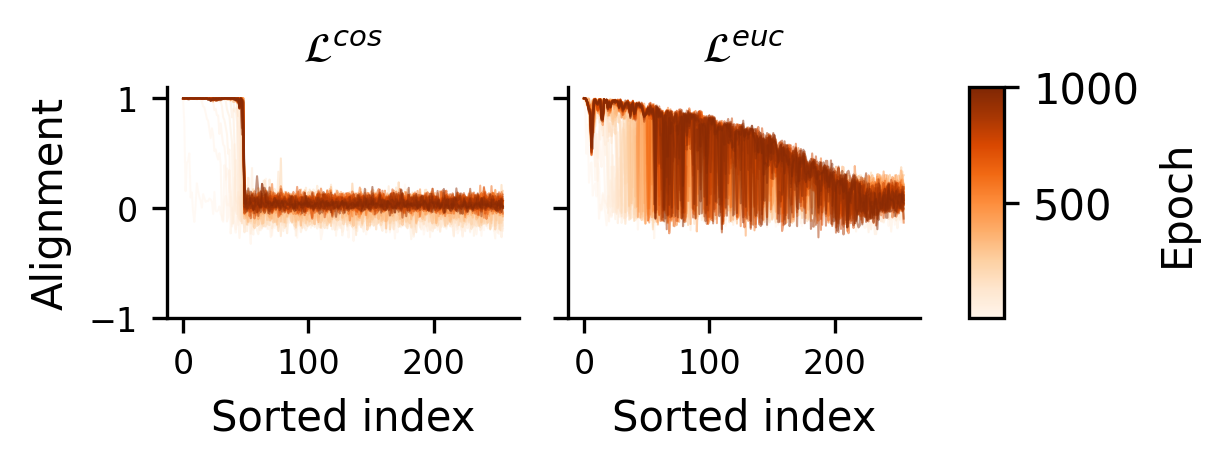

In [34]:
from matplotlib.gridspec import GridSpec
fig, axs = plt.subplots(1, 3, figsize=(3.6, 1.0), sharey=True, dpi=300)
# turn off the axes
for ax in axs:
    ax.axis('off')
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.1])

# Create subplots for your two panels
axs = [plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), None]
for i, (key, aligns) in enumerate(eigvec_align_dict.items()):
    N = aligns.shape[0] // 20
    cmap = plt.get_cmap('Oranges')

    ax = axs[i]
    ax.set_title(labels[key], fontsize=10)
    for k in range(N):
        ax.plot(aligns[k*20], color=cmap(k/N), alpha=0.5, lw=0.5)
    ax.set_xlabel("Sorted index", fontsize=10)
    if i == 0:
        ax.set_ylabel("Alignment", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    else:
        ax.set_yticklabels([])
    ax.set_ylim(-1, 1.1)
    ax.set_xticks([0, 100, 200])
    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine(ax=ax)

cax = plt.subplot(gs[0, 2])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=N*20))
sm._A = []
plt.colorbar(sm, cax=cax, label="Epoch")

## Eigenvalue trajectories comparing BYOL, DirectPred and IsoLoss for the two distance metrics (Figure 3)

In [ ]:
runs_to_plot = ['byol_euc', 'byol_cos', 'directpred_euc', 'directpred_cos', 'isoloss_euc', 'isoloss_cos']

eigvals_dict = {key: extract_eigvals(entity + '/' + project + '/' + run_ids[key]) for key in run_ids.keys() if key in runs_to_plot}

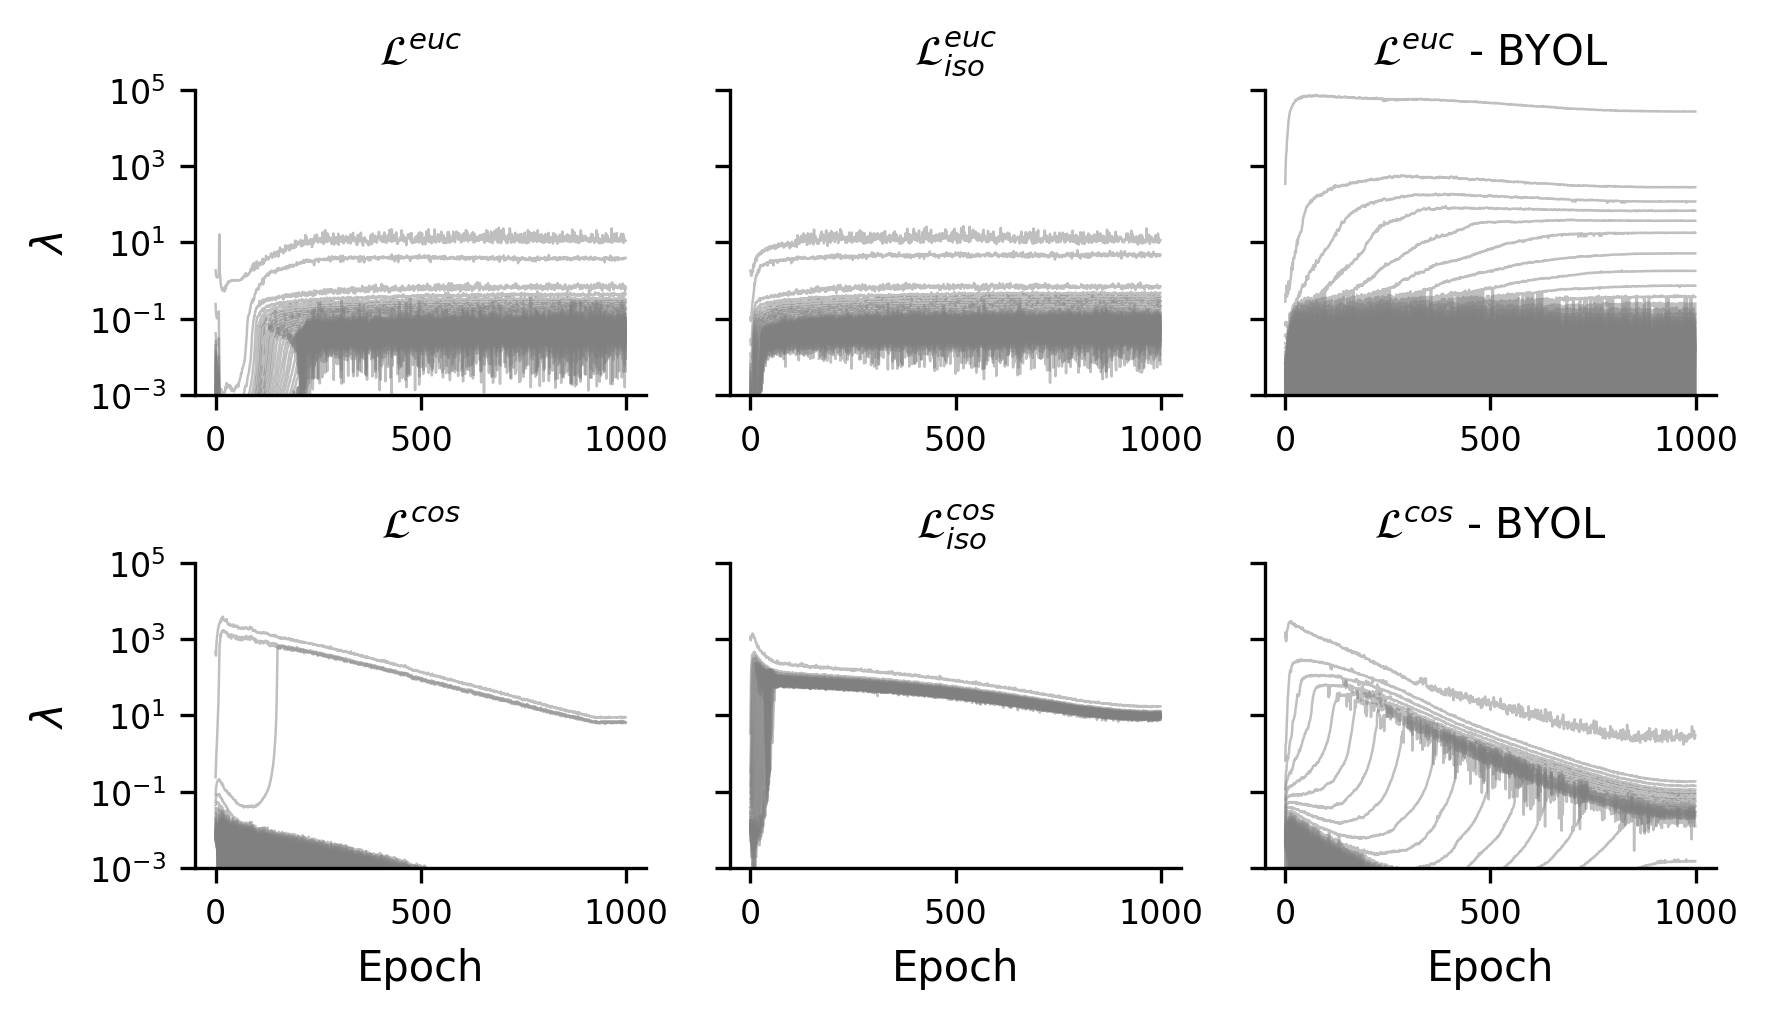

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(6.0, 3.5), sharey=True, dpi=300)
for key, eigenvalues in eigvals_dict.items():
    i = 0 if 'euc' in key else 1
    if 'directpred' in key:
        j = 0
    elif 'isoloss' in key:
        j = 1
    else:
        j = 2
    
    ax = axs[i, j]
    ax.semilogy(eigenvalues[:,::10], color='gray', alpha=0.5, linewidth=0.6)
    ax.set_title(labels[key], fontsize=10)
    ax.set_xlabel("Epoch", fontsize=10) if i == 1 else None
    ax.set_ylabel(r"$\lambda$", fontsize=10) if j == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(1e-3, 1e5)
sns.despine()
plt.tight_layout()


In [43]:
runs_to_plot = ['directpred_euc', 'directpred_cos', 'isoloss_euc', 'isoloss_cos']

val_acc_dict = {key: extract_val_acc(entity + '/' + project + '/' + run_ids[key]) for key in run_ids.keys() if key in runs_to_plot}

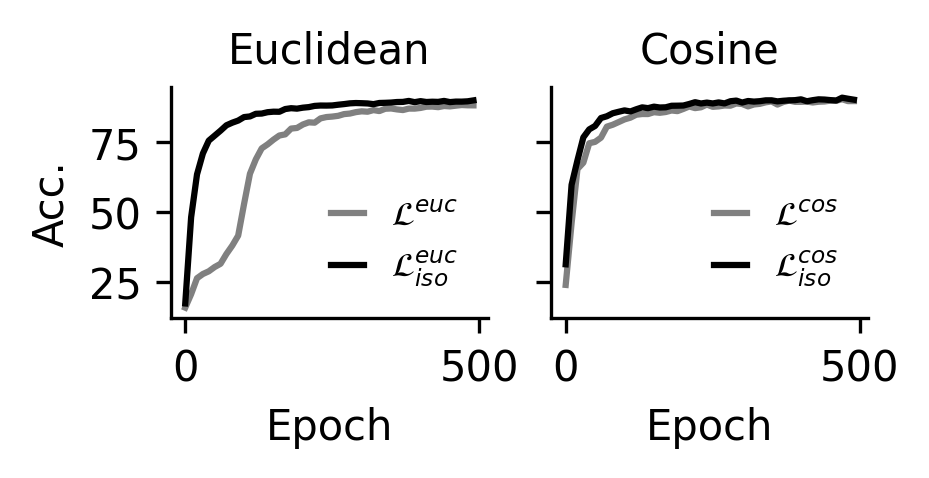

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(3.0, 1.0), sharey=True, dpi=300)

for key, val_acc in val_acc_dict.items():
    if 'euc' in key:
        i = 0
    else:
        i = 1
    
    if 'directpred' in key:
        color = 'gray'
        zorder = 0
    elif 'isoloss' in key:
        color = 'k'
        zorder = 1

    ax = axs[i]
    ax.set_title('Euclidean' if i == 0 else 'Cosine', fontsize=10)
    ax.plot(val_acc[:500][::10], color=color, zorder=zorder, label=labels[key])
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_xticks([0, 50])
    ax.set_xticklabels([0, 500])
    ax.set_ylabel("Acc.", fontsize=10) if i == 0 else None
    ax.legend(fontsize=8, frameon=False, handlelength=1, loc="lower right")
sns.despine()

## Effect of EMA (Figure 7)

In [ ]:
runs_to_plot = ['isoloss_cos_withema', 'isoloss_cos_noema']

eigvals_dict = {key: extract_eigvals(entity + '/' + project + '/' + run_ids[key]) for key in run_ids.keys() if key in runs_to_plot}

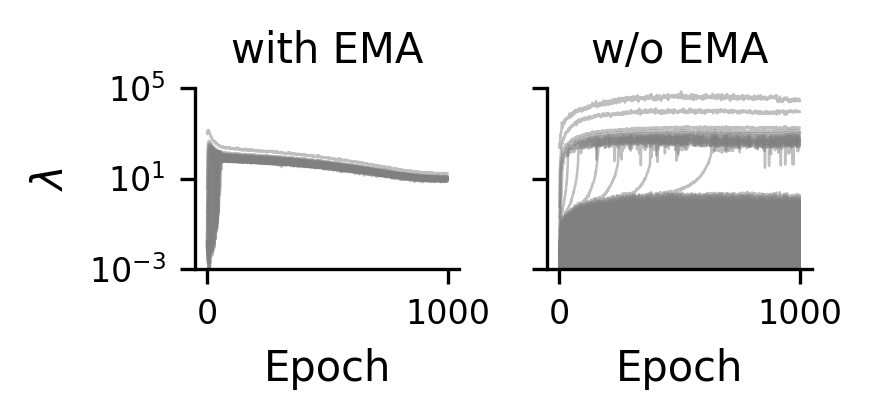

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(3.0, 1.5), sharey=True, dpi=300)

for key, eigenvalues in eigvals_dict.items():
    if 'withema' in key:
        i = 0
    elif 'noema' in key:
        i = 1
    
    ax = axs[i]
    ax.semilogy(eigenvalues[:,::10], color='gray', alpha=0.5, linewidth=0.6)
    ax.set_title(labels[key], fontsize=10)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(r"$\lambda$", fontsize=10) if i == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(1e-3, 1e5)
sns.despine()
plt.tight_layout()


### Effect of weight decay (Figure 8)

In [ ]:
runs_to_plot = ['isoloss_cos_wd_4e-4', 'isoloss_cos_wd_1e-5', 'isoloss_cos_wd_1e-6', 'directpred_cos_wd_4e-4', 'directpred_cos_wd_1e-5', 'directpred_cos_wd_1e-6']

eigvals_dict = {key: extract_eigvals(entity + '/' + project + '/' + run_ids[key]) for key in run_ids.keys() if key in runs_to_plot}

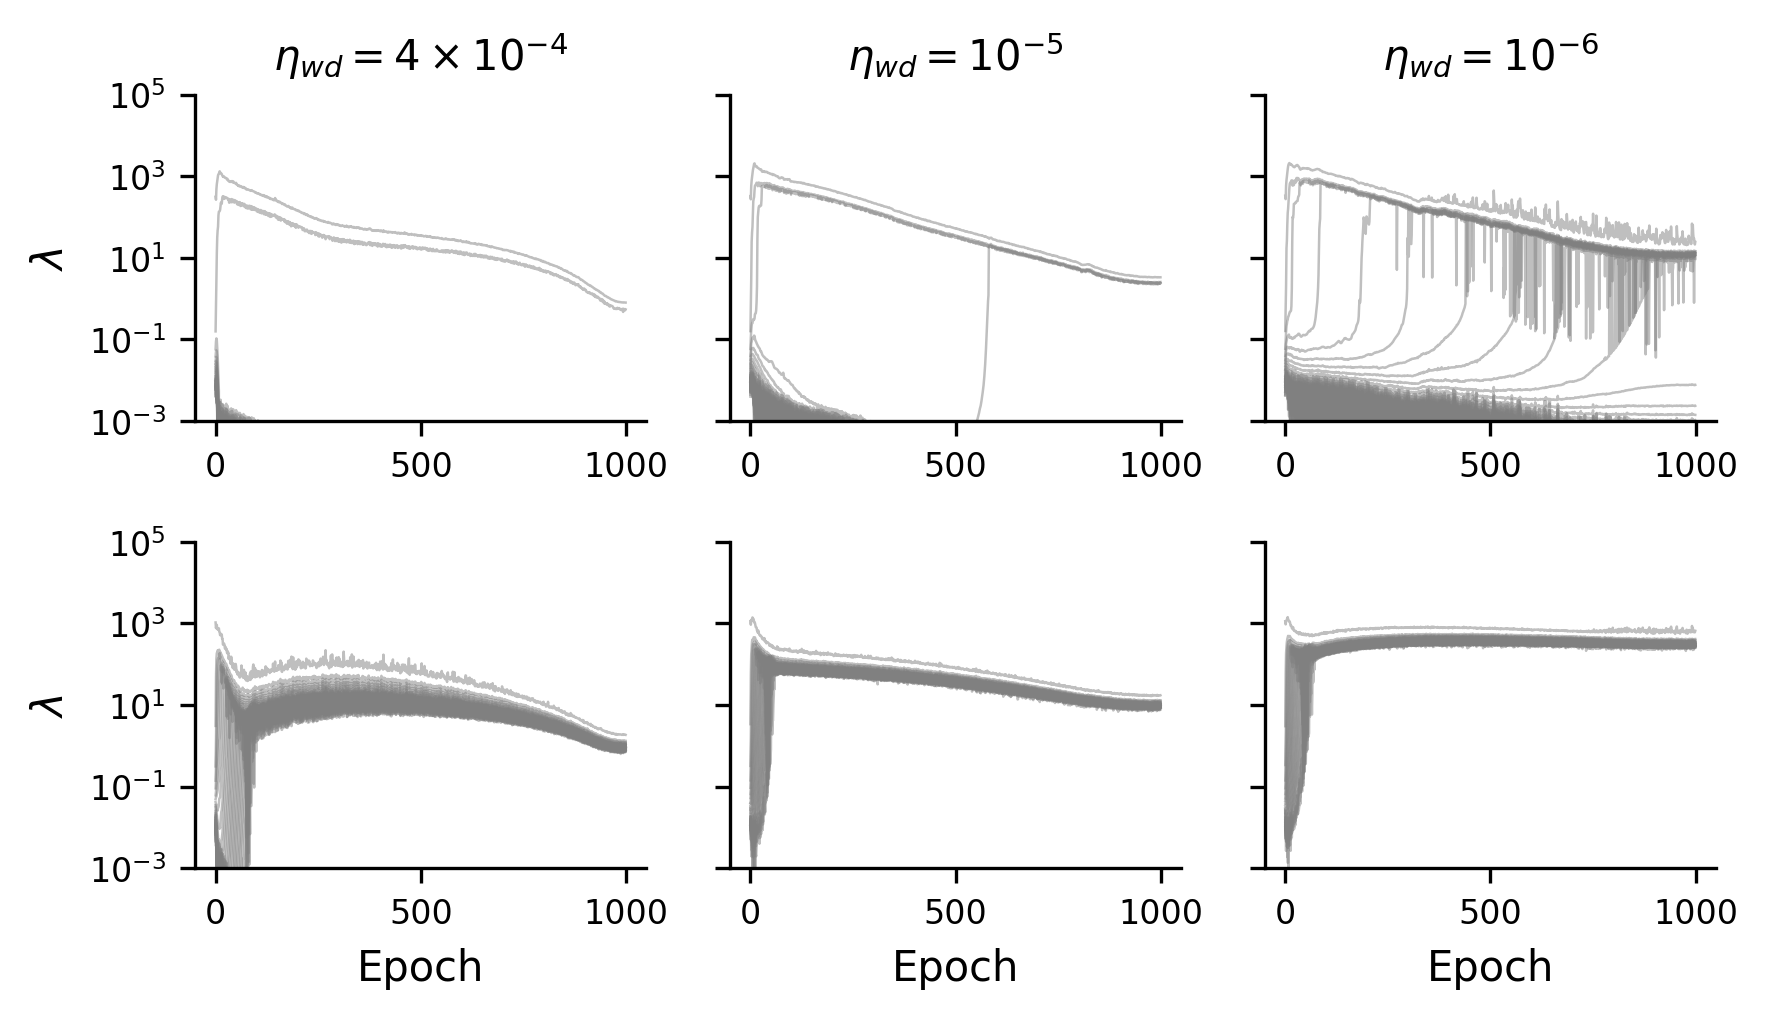

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(6.0, 3.5), sharey=True, dpi=300)

for key, eigenvalues in eigvals_dict.items():
    if 'isoloss' in key:
        i = 1
    elif 'directpred' in key:
        i = 0
    
    if '4e-4' in key:
        j = 0
    elif '1e-5' in key:
        j = 1
    elif '1e-6' in key:
        j = 2
    
    ax = axs[i, j]
    ax.semilogy(eigenvalues[:,::10], color='gray', alpha=0.5, linewidth=0.6)
    ax.set_title(labels[key], fontsize=10) if i == 0 else None
    ax.set_xlabel("Epoch", fontsize=10) if i == 1 else None
    ax.set_ylabel(r"$\lambda$", fontsize=10) if j == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(1e-3, 1e5)
sns.despine()
plt.tight_layout()